# 3 - AlexNet

In this notebook we will be implementing a modified version of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), a neural network model that uses convolutional neural network (CNN) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/). AlexNet is famous for winning the ImageNet challenge in 2012 by beating the second place competitor by over 10% accuracy and kickstarting the interest in deep learning for computer vision.

The image below shows the architecture of AlexNet.

![](assets/alexnet.png)

Confusingly, there are two "paths" of processing through the network. This is due to the original AlexNet model being implemented on two GPUs in parallel. Almost all implementations of AlexNet are now on a single GPU and our implementation is too.

We are now moving on from the MNIST dataset and from now on we will be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/cifar10.png?raw=1)

We will also show how to initialize the weights of our neural network and how to find a suitable learning rate using a modified version of the [learning rate finder](https://arxiv.org/abs/1506.01186).

Like the previous notebooks we'll implement our model, measure its performance on the dataset, and then have a short look into seeing what the model has learned.

Most of this notebook will be similar to the previous ones thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need. A new import is the `_LRScheduler` which we will use to implement our learning rate finder.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import os
import csv

import cv2 as cv, numpy as np
import copy
import random
import time

C:\Users\13664\anaconda3\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We set the random seed so all of our experiments can be reproduced.

In [2]:
dir_img = './images'
dir_label = './label'

class ImageFile(object):
    def __init__(self, phase="train"):
        self.phase = phase
    
    def _get_filenames_(self, file_dir):
        list =os.listdir(file_dir)
        list.sort(key=lambda x: int(x[0:-4]))
        return list
    
    def _list_abspath(self, file_dir, file_list):
        return [os.path.join(file_dir, file_name) for file_name in file_list]

    def _get_labels_(self, dir_label):
        with open(dir_label + '/label_.csv', 'r') as f:
            reader = csv.reader(f)
            data = list(reader)
            eyes = [row[1] for row in data]
            hair = [row[2] for row in data]
            mouth_open = [row[3] for row in data]
            gender = [row[4] for row in data]
            glasses = [row[5] for row in data]
        return [eyes, hair, mouth_open, gender, glasses]
    
    
class TrainDataset(ImageFile):
    def __init__(self):
        super(TrainDataset, self).__init__(phase="train")
        
        self.img_dir = dir_img
        self.label_dir = dir_label
        
        self.img_list = self._get_filenames_(self.img_dir)

        self.labels = self._get_labels_(self.label_dir)
        self.img = self._list_abspath(self.img_dir, self.img_list)
        
    
    def __len__(self):
        return len(self.img)
    

class ToTensor(object):
    """
    Convert ndarrays in dataset to Tensors with normalization.
    """
    def __init__(self, phase="train"):
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1) # 
        self.std = torch.tensor([0.5,  0.5, 0.5]).view(3,1,1) #
        self.phase = phase

    def __call__(self, sample):
        
        if self.phase == "train":
            # convert BGR images to RGB
            # swap color axis because
            # numpy image: H x W x C
            # torch image: C X H X W
            img = sample['img'][:,:,::-1].transpose((2, 0, 1)).astype(np.float32) / 255.
            sample['img'] = torch.from_numpy(img).sub_(self.mean).div_(self.std)
            # del sample['image_name']

        sample['label'] = torch.tensor(sample['label']).to(torch.long)             

        return sample

def color2code(color):
    code = np.zeros(11)
    code[color - 1] = 1
    return color - 1

def bool2code(bool_):
    code = np.zeros(2)
    code[bool_] = 1
    return bool_

def feature2code(sample):
    eyes = color2code(sample['eyes'])
    hair = color2code(sample['hair'])
    mouth_open = bool2code(sample['mouth_open'])
    gender = bool2code(sample['gender'])
    glasses = bool2code(sample['glasses'])
    #code = np.concatenate((eyes, hair, mouth_open, gender, glasses))
    code = hair
    return code

class dataLoader(Dataset):
    def __init__(self, data, phase = "train"):
        self.phase = phase
        self.img = data.img
        self.eyes = data.labels[0]
        self.hair = data.labels[1]
        self.mouth_open = data.labels[2]
        self.gender = data.labels[3]
        self.glasses = data.labels[4]
        self.img_list = data.img_list
        
        self.transform = {
            'train':
                transforms.Compose([ToTensor()]),
            'val':
                transforms.Compose(ToTensor()),
            'test':
                transforms.Compose(ToTensor())}[phase]

        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img = cv.imread(self.img[idx])
        name = self.img_list[idx]
        eyes = int(self.eyes[idx])
        hair = int(self.hair[idx])
        mouth_open = int(self.mouth_open[idx])
        gender = int(self.gender[idx])
        glasses = int(self.glasses[idx])
        sample = {'img': img, 'eyes': eyes, 'hair': hair, 'mouth_open': mouth_open, 'gender': gender, 'glasses': glasses, 'name': name}  
        label = feature2code(sample)
        sample.update({'label': label})
        sample = self.transform(sample)
        return sample
    
    
dataset = TrainDataset()
t_data = dataLoader(dataset)


In [3]:
n_train_examples = 10431
n_valid_examples = 1159

train_data, valid_data = data.random_split(t_data,
                                           [n_train_examples, n_valid_examples])

In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 10431
Number of validation examples: 1159


In [5]:
BATCH_SIZE = 61

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)


In [6]:
OUTPUT_DIM = 6

In [7]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = nn.Sequential(
        nn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        nn.BatchNorm2d(chann_out),
        nn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ nn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return nn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = nn.Sequential(
        nn.Linear(size_in, size_out),
        nn.BatchNorm1d(size_out),  
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    return layer

class VGG16(nn.Module):
    def __init__(self, n_classes=6):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        self.layer6 = vgg_fc_layer(4*4*512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = nn.Linear(4096, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        vgg16_features = out
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return out


In [8]:
model = VGG16(OUTPUT_DIM)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 58,021,446 trainable parameters


In [10]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        sample = iterator.get_batch()

        x = sample['img'].to(self.device)
        y = sample['label'].to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            sample = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            sample = next(self._iterator)

        return sample

    def get_batch(self):
        return next(self)

In [11]:
START_LR = 1e-7

optimizer = optim.SGD(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [12]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we can plot the learning rate against the loss. 

As our learning rate was scaled up exponentially we want to plot it on a logarithmic scale. We also do not want to plot the last few values as they are usually where the loss is very high and makes it difficult to examine the graph in detail. You can also skip the first few values as nothing interesting happens there.

In [13]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see, the loss begins flat and then begins to decrease rapidly before reaching a minimum and starting to increase. 

How can we read this plot and get the optimal learning rate? According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article, we should look for the loss begins to flatten, this is around $10^{-2}$ below, and then reduce that by a factor of 10, which gives us a found learning rate of $10^{-3}$ or $0.001$.

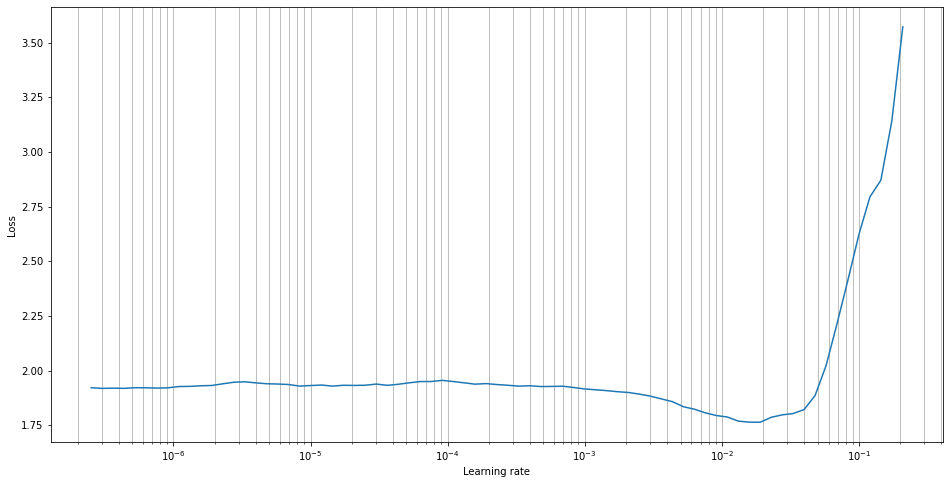

In [14]:
plot_lr_finder(lrs, losses)

We can now create a new optimizer with our found learning rate.

Ironically, the learning rate value we found, $0.001$ is actually Adam's default learning rate!

In [10]:
FOUND_LR = 1e-2
'''

'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.SGD(model.parameters(), lr=FOUND_LR)

The rest of the notebook is pretty similar to the previous notebooks from these tutorials.

We define a function to calculate accuracy...

In [11]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...and a function to implement our training loop.

As we are using dropout we need to make sure to "turn it on" when training by using `model.train()`.

In [12]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for sample in iterator:

        x = sample['img'].to(device)
        y = sample['label'].to(device)

        optimizer.zero_grad()

        y_pred= model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We also define an evaluation loop, making sure to "turn off" dropout with `model.eval()`.

In [13]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for sample in iterator:

            x = sample['img'].to(device)
            y = sample['label'].to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Next, we define a function to tell us how long an epoch takes.

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

We get a best validation loss of ~76% accuracy.

In [15]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'hair.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 23s
	Train Loss: 1.168 | Train Acc: 59.65%
	 Val. Loss: 0.970 |  Val. Acc: 70.41%
Epoch: 02 | Epoch Time: 5m 11s
	Train Loss: 1.011 | Train Acc: 67.17%
	 Val. Loss: 0.964 |  Val. Acc: 70.06%
Epoch: 03 | Epoch Time: 5m 7s
	Train Loss: 0.926 | Train Acc: 69.63%
	 Val. Loss: 0.862 |  Val. Acc: 73.17%
Epoch: 04 | Epoch Time: 5m 6s
	Train Loss: 0.819 | Train Acc: 72.45%
	 Val. Loss: 0.993 |  Val. Acc: 68.08%
Epoch: 05 | Epoch Time: 5m 4s
	Train Loss: 0.685 | Train Acc: 76.77%
	 Val. Loss: 0.931 |  Val. Acc: 69.37%
Epoch: 06 | Epoch Time: 5m 7s
	Train Loss: 0.561 | Train Acc: 80.60%
	 Val. Loss: 0.818 |  Val. Acc: 72.48%
Epoch: 07 | Epoch Time: 5m 7s
	Train Loss: 0.431 | Train Acc: 85.60%
	 Val. Loss: 0.536 |  Val. Acc: 83.00%
Epoch: 08 | Epoch Time: 5m 7s
	Train Loss: 0.324 | Train Acc: 89.67%
	 Val. Loss: 0.496 |  Val. Acc: 86.02%
Epoch: 09 | Epoch Time: 5m 5s
	Train Loss: 0.267 | Train Acc: 91.61%
	 Val. Loss: 0.578 |  Val. Acc: 82.83%
Epoch: 10 | Epoch Time: 5m

We then load the parameters of our model that achieved the best validation loss and evaluate this model on the test set to achieve a ~75% accuracy.

In [38]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.724 | Test Acc: 74.79%


### Examining the Model

We will do the exact same probing into our model as we did in the previous notebooks: plotting a confusion matrix, plotting the most confident incorrect predictions, using PCA and t-SNE, and viewing the learned weights of our model.

First, we'll collect all the predictions.

In [39]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [40]:
images, labels, probs = get_predictions(model, test_iterator, device)

Then, for each prediction we get the predicted class.

In [41]:
pred_labels = torch.argmax(probs, 1)

Next, we plot the confusion matrix. This time we have edited the function to allow us to pass a list of strings which are the labels classes.

In [42]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

The two classes our model seems to get mixed up the most is cat and dog.

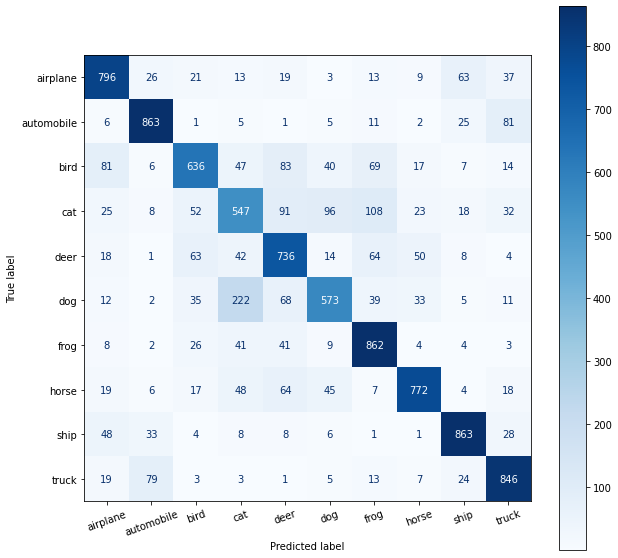

In [43]:
plot_confusion_matrix(labels, pred_labels, classes)

We can then find which predictions were correct and then sort the incorrect predictions in descending order of their confidence.

In [44]:
corrects = torch.eq(labels, pred_labels)

In [45]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [46]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

Interestingly, the most incorrect was an example that is incorrectly labelled in the dataset itself. It is clearly a frog, which our model predicted with 100% confidence, but the label is cat.

Truck and automobile seem to be confused a lot but even to humans these two classes are slightly ambiguous.

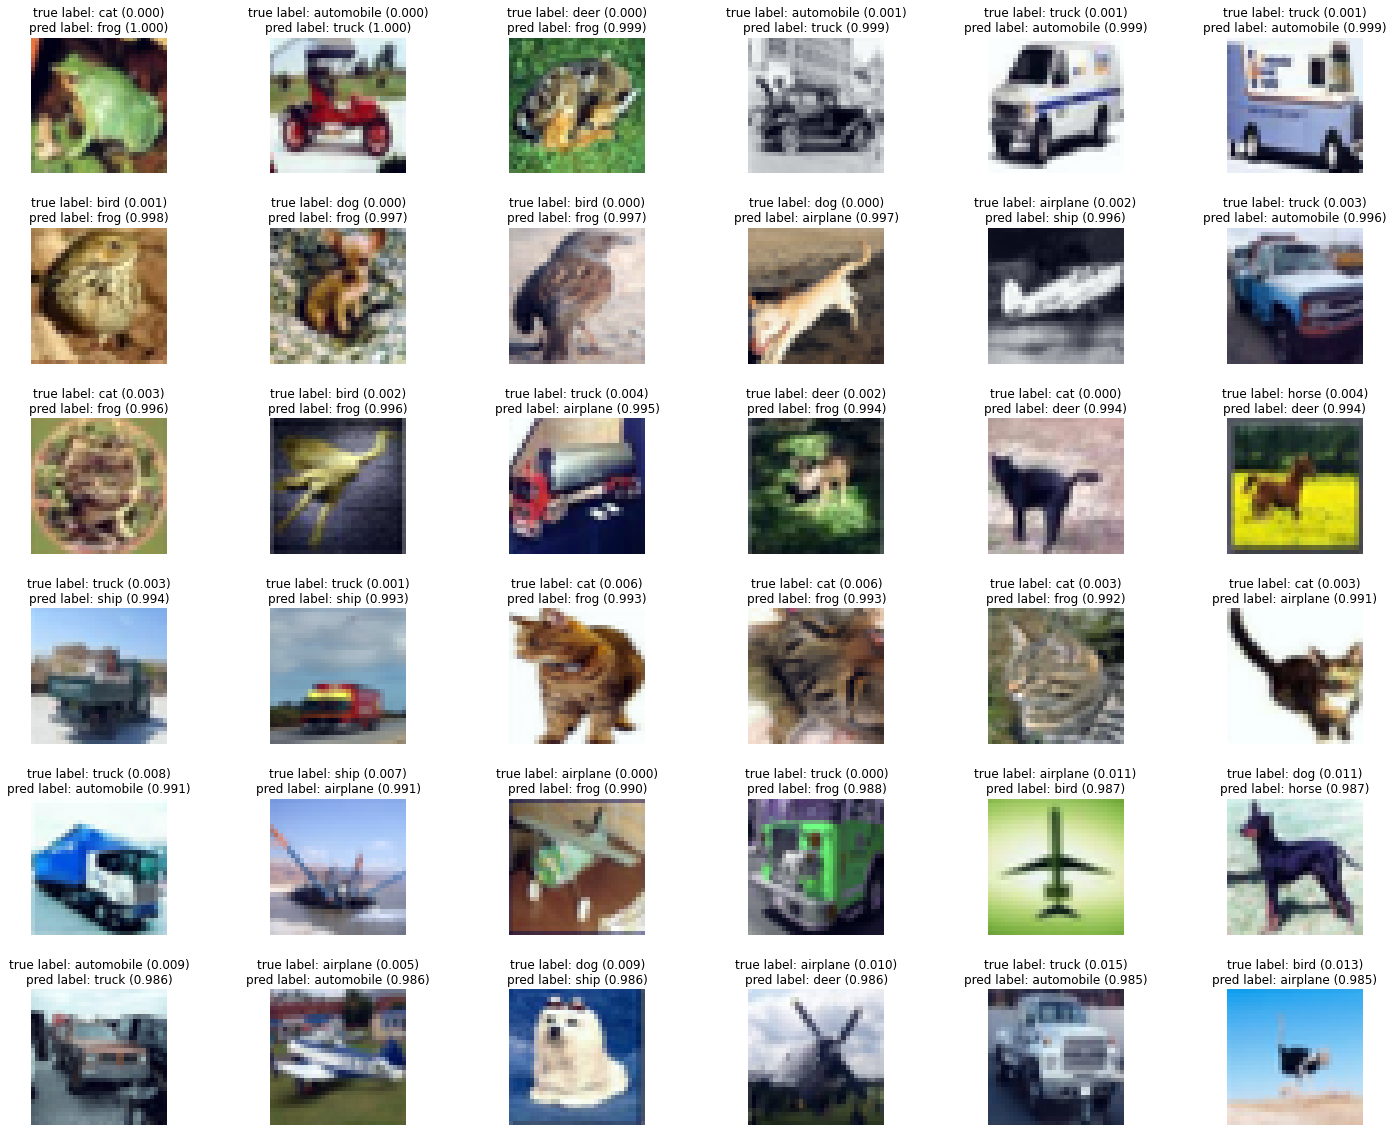

In [47]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

Next, we'll get the output and intermediate (after the flatten) representations.

In [48]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [49]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

We can then perform PCA on them both and plot them.

In [50]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [51]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

Like previous notebooks, the classes seem more separated in the output representations than the intermediate representations.

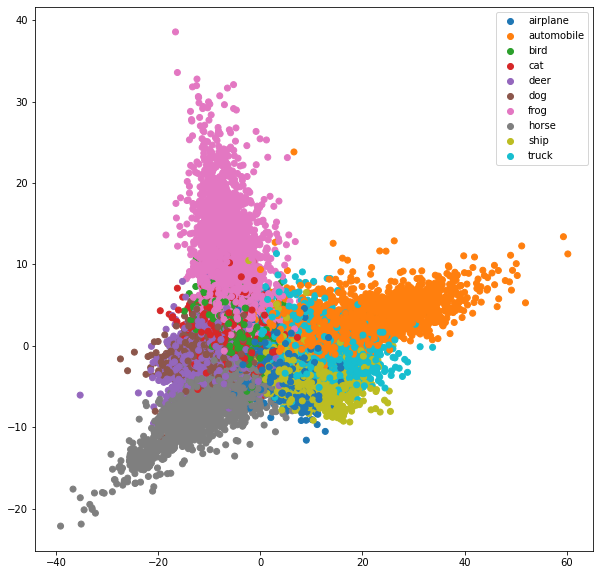

In [52]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

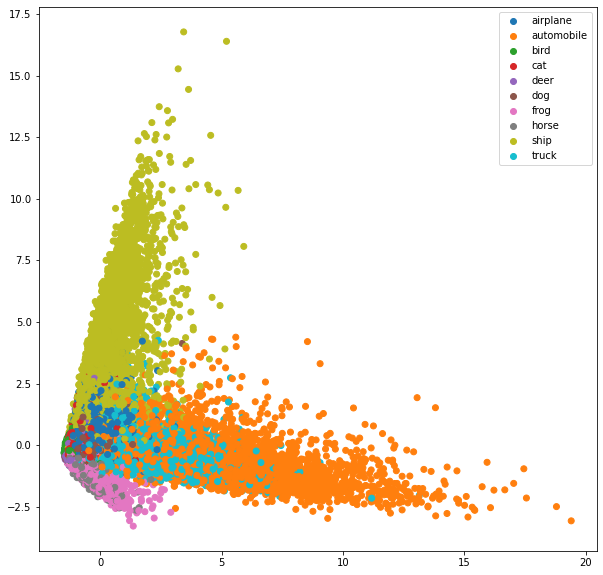

In [53]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels, classes)

We can do the same with the t-SNE algorithm. 

Again, we only use a subset of the data as t-SNE takes a considerable amount of time to compute.

We also see that the classes are more well separated in the output representations compared to the intermediate representations.

In [54]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

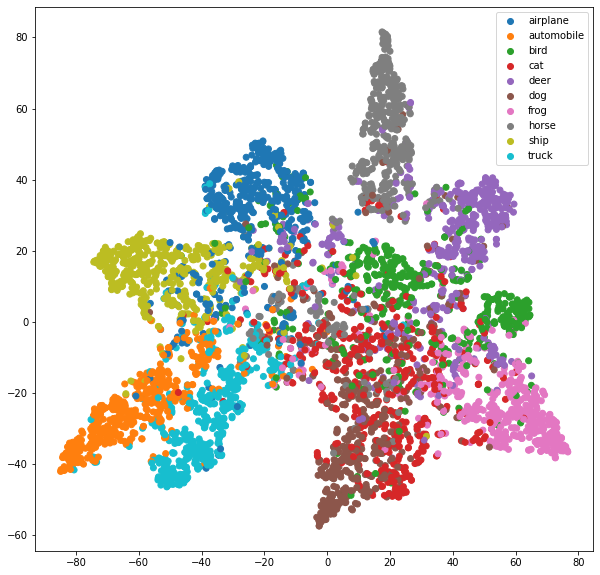

In [55]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

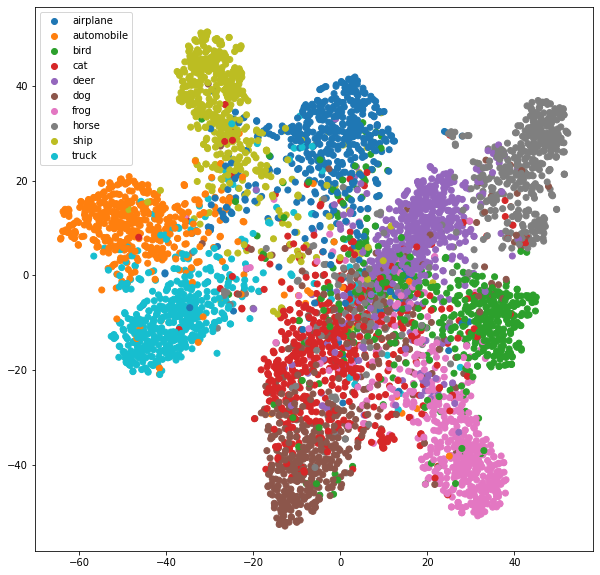

In [56]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images=N_IMAGES)

We can also imagine an image belonging to a specified class. 

Spoilers: this didn't work in the previous notebooks, won't work here, and won't work in the future. This is the last time we'll attempt to generate an image.

If you do know a simple method to generate images that look better than pure random noise, feel free to [submit an issue](https://github.com/bentrevett/pytorch-image-classification/issues) on how it is done and it can be added to these tutorials.

In [57]:
def imagine_image(model, classes, image, device, n_iterations=10_000):

    model.eval()

    label = classes.index(image)

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(256, 3, 32, 32).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, label], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [58]:
IMAGE = 'frog'

best_image, best_prob = imagine_image(model, classes, IMAGE, device)

We get an image that our model is ~100% confident is a frog, but just looks like random noise.

In [59]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


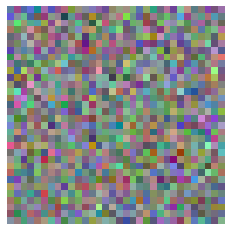

In [60]:
best_image = normalize_image(best_image)

plt.imshow(best_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off');

Next, we'll plot some images after they have been convolved with the first convolutional layer.

In [61]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

We can see different types of edge detection and blurring that the filters have learned that are apparently decent feature extractors for this model and task.

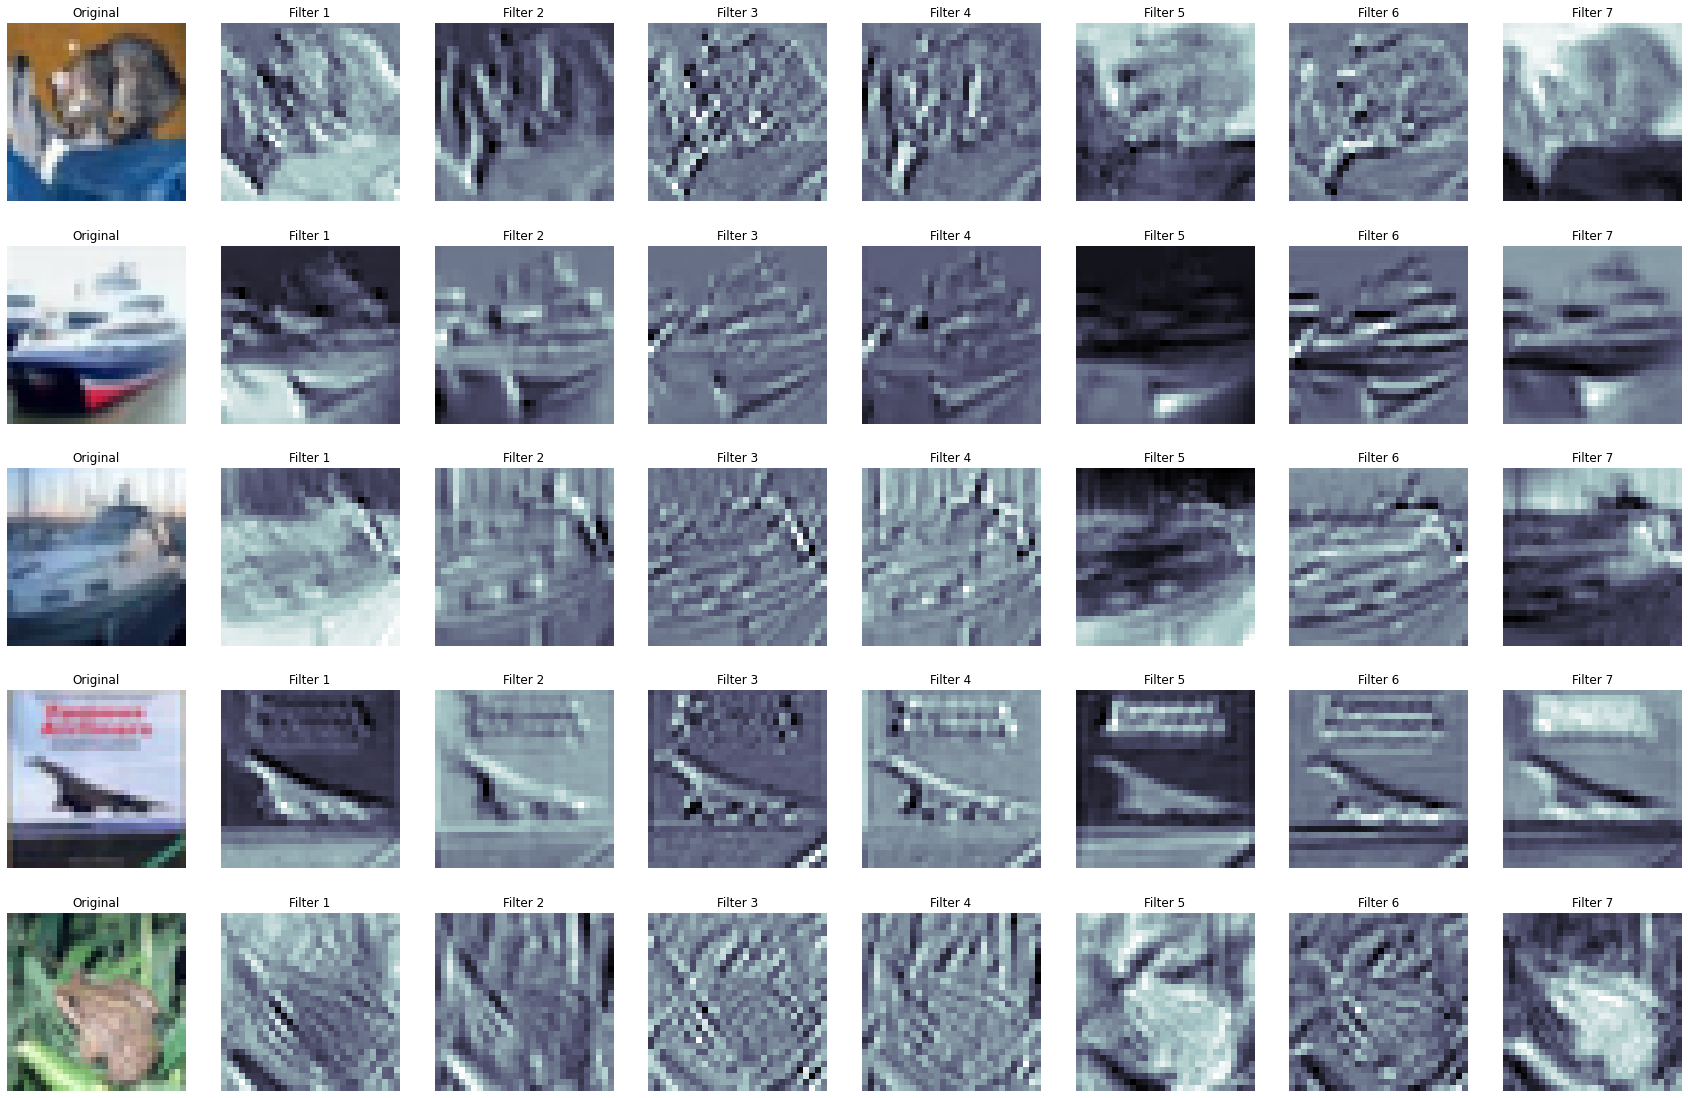

In [62]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the actual filters our model has learned.

In [63]:
def plot_filters(filters, normalize=True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Again, nothing really interpretable here, sadly.

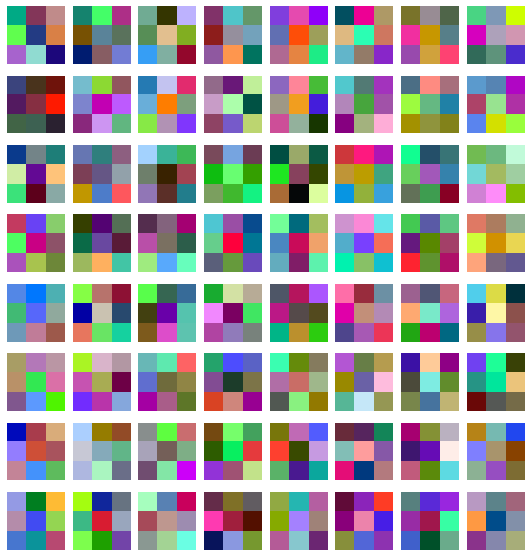

In [64]:
plot_filters(filters)

Can we ever learn interesting looking filters? Or are we doomed to just look at colorful blocks forever?

Well, we can take a *pre-trained* AlexNet model and view the filters of that. This pre-trained version of AlexNet was trained by people at PyTorch and was not trained on the CIFAR10 dataset, but on the [ILSVRC](https://arxiv.org/abs/1409.0575) dataset, usually just called the ImageNet dataset. ImageNet is a dataset with over 1 million images in 1,000 classes. Torchvision provides ways of downloading different models pre-trained on ImageNet, such as AlexNet and [many others](https://pytorch.org/vision/stable/models.html).  

First, we can import the model making sure to pass `pretrained = True` to get a pre-trained version. Torchvision will then import the model, download the weights for it and load them into the new model.

We can see that this is similar to our AlexNet model but has considerably more parameters.

One interesting thing is that they use much larger filters in the first convolutional layer - 11x11 instead of 3x3.

In [65]:
model = models.alexnet(pretrained=True)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can then get the learned values of these filters the same way we did for our version of AlexNet and then plot them.

As we can see the patterns are much more interesting, though still not really interpretable.

So how come it learned these interesting looking filters? Is it just because the filters are bigger? Is it because models can only do well on ImageNet if they learn more interesting filters? Or something else?

Do more interesting looking filters imply that they perform better? Or are these filters showing how the model has overfit to patterns on the images within ImageNet?

It is difficult to answer these questions as modern computer vision architectures now seem to favour smaller filter sizes with their largest filters being 5x5 - so maybe larger filters aren't that good after all?

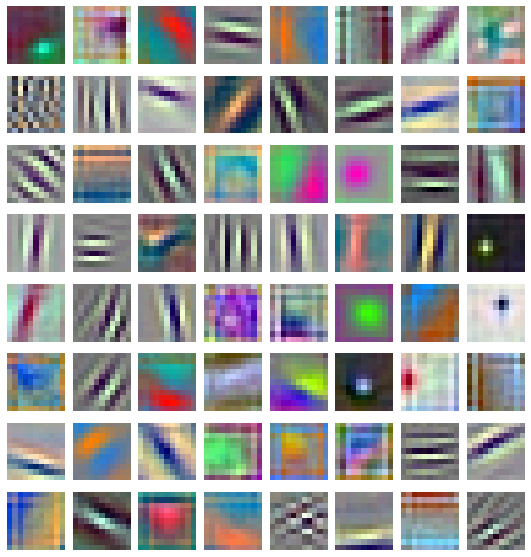

In [66]:
filters = model.features[0].weight.data

plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- defining a CNN (AlexNet)
- custom weight initialization
- how to use the learning rate finder
- training a model to achieve >75% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake images
- viewing the learned weights of our model
- loading a pre-trained model

In the next notebook we'll implement a popular CNN architecture, VGG, and learn about how to actually use pre-trained models on our dataset.